## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Loading the data set

The data set is assigned to a Pandas data frame.

In [2]:
new_df = pd.read_csv('/content/new_df.csv', index_col=0, decimal='.')

# CLUSTERING

## Clustering Preprocessing - Normalization
First thing to do in clustering is to normalize data. We used `MinMaxScaler` to do this.

In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_transformed = scaler.fit_transform(new_df.values)

## K-Means
Parameters:
* **K**: the number of clusters.

We exploited the Elbow method to find the best value for `K`, calculating the mean of SSE for each value from 1 to 20 clusters.

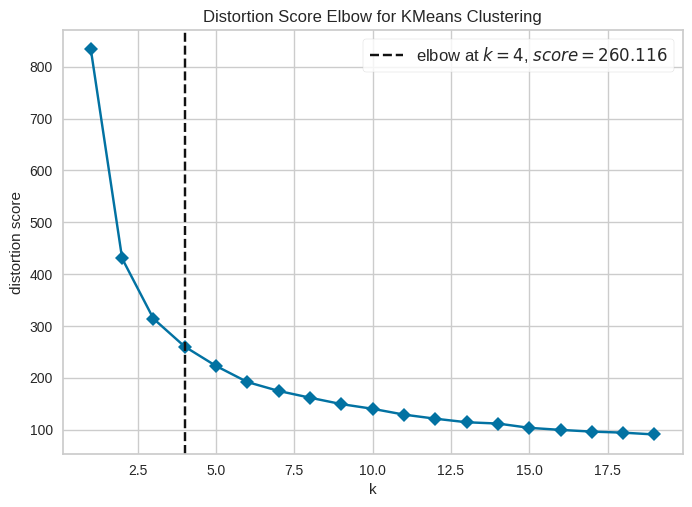

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [4]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
km = KMeans()
visualizer = KElbowVisualizer(
    km, k=(1,20), metric='distortion', timings=False)
visualizer.fit(df_transformed)
visualizer.show()

Then, we applied K-Means with the previously found value.

In [5]:
n_clusters = visualizer.elbow_value_
kmeans = KMeans(n_clusters=n_clusters, n_init=20, max_iter=100)
kmeans.fit(df_transformed)
hist, bins = np.histogram(kmeans.labels_,
                          bins=range(0, len(set(kmeans.labels_)) + 1))

This is the size of the retrieved clusters.

In [6]:
dict(zip(bins, hist))

{0: 1660, 1: 1165, 2: 2415, 3: 409}

Visualization of cluster in two dimensions.

(`I` and `BasketNum`)

<ipython-input-7-c90864000d37>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(new_df['I'], new_df['BasketNum'], c=kmeans.labels_, s=20, cmap=plt.cm.get_cmap('jet'))


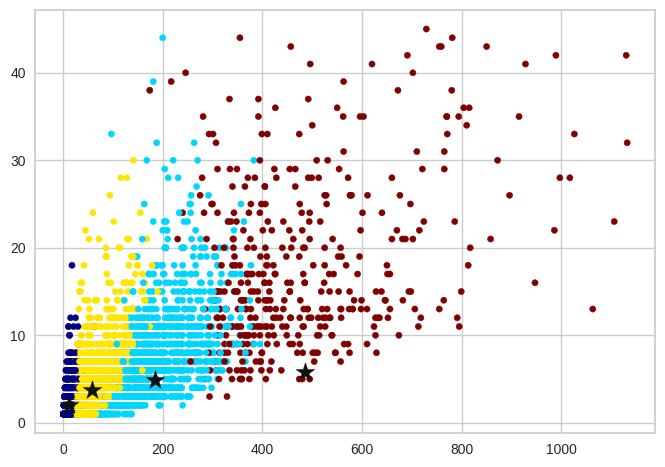

In [7]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(new_df['I'], new_df['BasketNum'], c=kmeans.labels_, s=20, cmap=plt.cm.get_cmap('jet'))
plt.scatter(centers[:, 0], centers[:, 3], s=200, marker='*', c='k')
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

Visualization of cluster in three dimensions.

(`I`, `BasketNum`, and `SumExp`)

<ipython-input-10-f930093270f8>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  new_df['SumExp'], c=kmeans.labels_, marker='o', cmap=plt.cm.get_cmap('jet'))


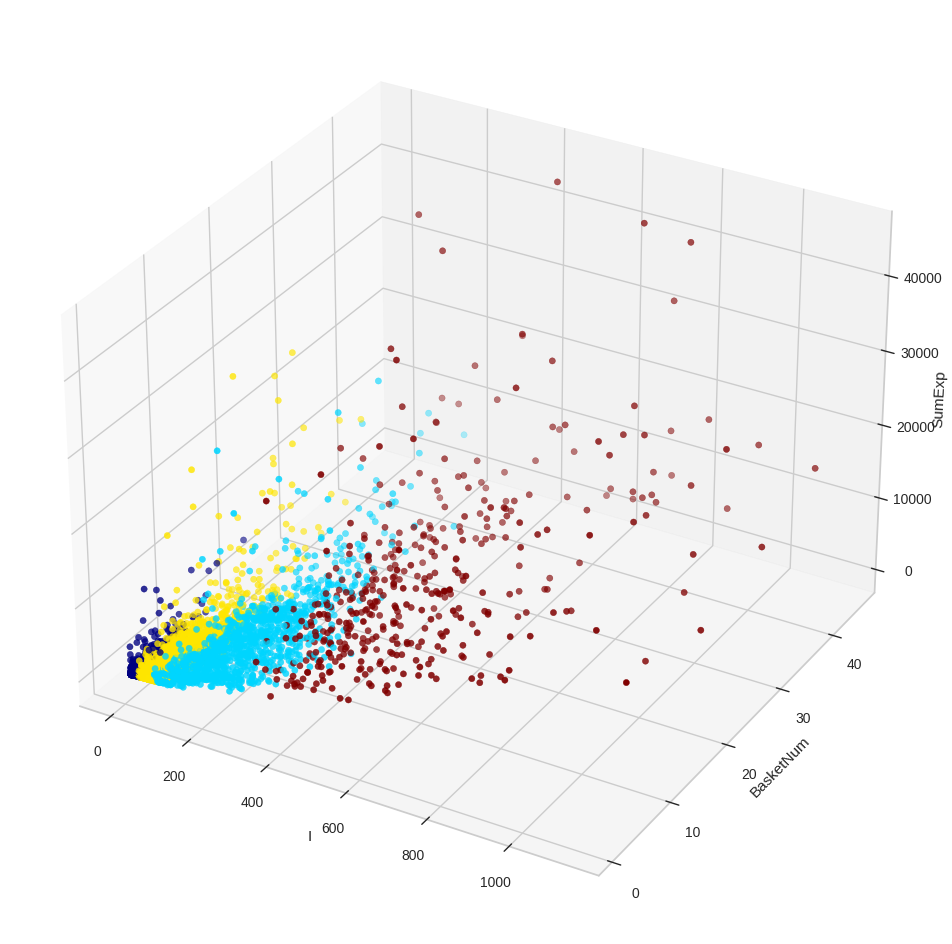

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # This import is necessary for 3D plotting

fig = plt.figure(figsize=(16,12))
ax2 = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

# Assuming new_df is your DataFrame and 'I', 'BasketNum', 'SumExp' are the columns
ax2.scatter(new_df['I'],
            new_df['BasketNum'],
            new_df['SumExp'], c=kmeans.labels_, marker='o', cmap=plt.cm.get_cmap('jet'))

ax2.set_xlabel('I')
ax2.set_ylabel('BasketNum')
ax2.set_zlabel('SumExp')

plt.show()

*Parallel coordinates* to find patterns in our dataset.

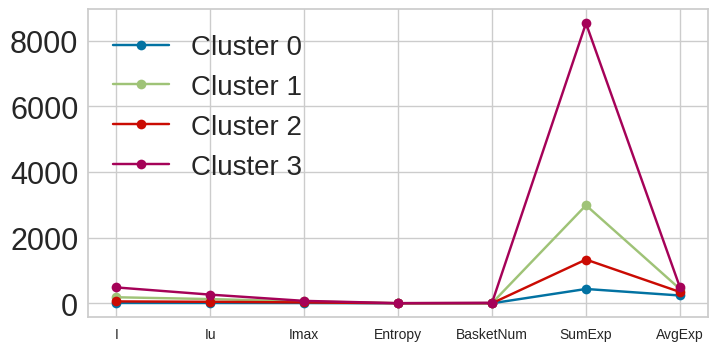

In [9]:
plt.figure(figsize=(8, 4))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(range(0, len(new_df.columns)), new_df.columns, fontsize=10)
plt.legend(fontsize=20)
plt.show()

## DBSCAN

Parameters:
* **eps**: The maximum distance between two samples for them to be considered as in the same neighborhood.
* **min_samples**: The number of samples in a neighborhood for a point to be considered as a core point. This includes the point itself.

`min_samples` was set to twice the dimension of our dataset.

In [ ]:
pip install kneed


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

min_pts = new_df.shape[1] * 2

Also for `DBSCAN` we exploited the Elbow/Knee Method,
to find the best value for `eps`

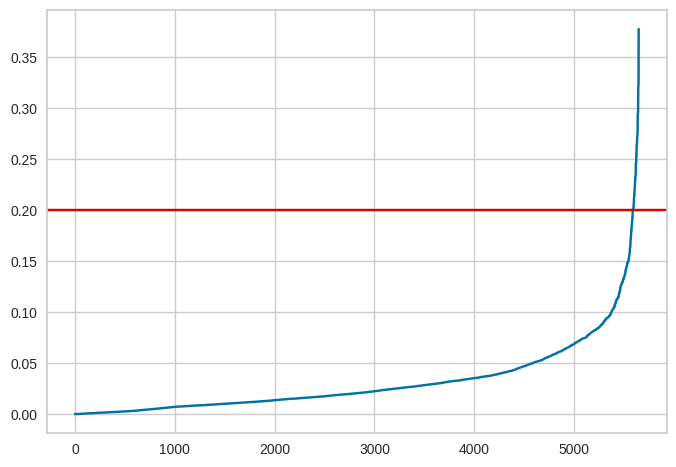

In [ ]:
neighbors = NearestNeighbors(n_neighbors=min_pts)
neighbors_fit = neighbors.fit(df_transformed)
distances, indices = neighbors_fit.kneighbors(df_transformed)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
kneedle = KneeLocator(range(distances.shape[0]), distances, S=1.0, curve="convex", direction="increasing")
plt.plot(range(distances.shape[0]), distances)
eps = kneedle.knee_y
plt.axhline(y=eps, color='r', linestyle='-', label="eps")
plt.show()

We applied `DBSCAN` with different parameter values.
Here we reported the run with the values found with Knee Method.

In [ ]:
dbscan = DBSCAN(eps=eps, min_samples=min_pts)
dbscan.fit(df_transformed)

DBSCAN(eps=0.20037554960966417, min_samples=14)

In [ ]:
labels, counts = np.unique(dbscan.labels_, return_counts=True)
print(labels, counts)

[-1  0] [ 119 5530]


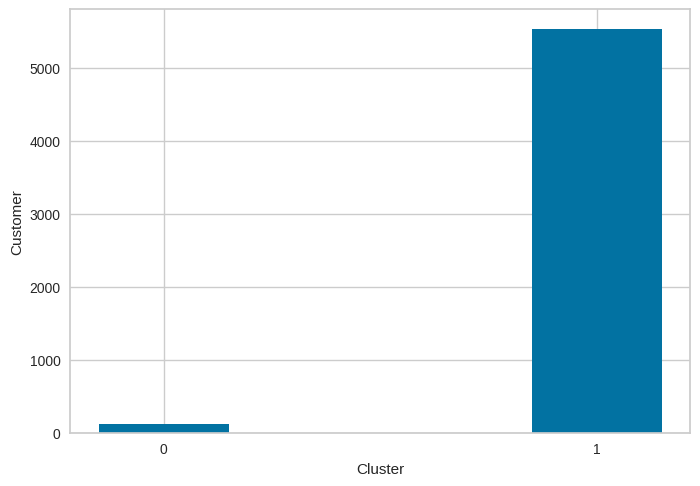

In [ ]:
plt.bar(x=range(len(counts)), height=counts, width=0.3)
plt.xticks(np.arange(2))
plt.xlabel("Cluster")
plt.ylabel("Customer")
plt.show()


## Hierarchical Clustering

In [ ]:
print("Infinite values in data:", np.isinf(df_transformed).sum())
print("NaN values in data:", np.isnan(df_transformed).sum())

Infinite values in data: 0
NaN values in data: 0


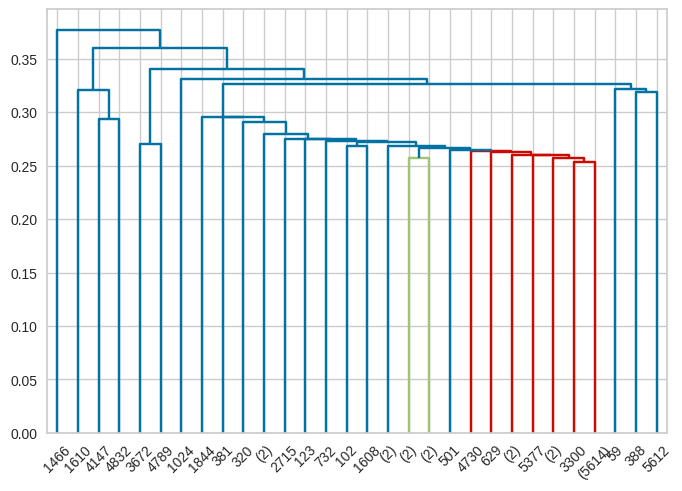

In [ ]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# auxiliary funciton to generate dendrogram with
# given method and metric
def hierarchical(method, metric):
    data_dist = pdist(df_transformed, metric=metric)
    data_link = linkage(data_dist, method=method)
    dendrogram(data_link, truncate_mode='lastp')
    plt.show()

# Try with 'euclidean' metric and different linkage methods
hierarchical(method='single', metric='euclidean')


Some other examples of `hierarchical` function application.

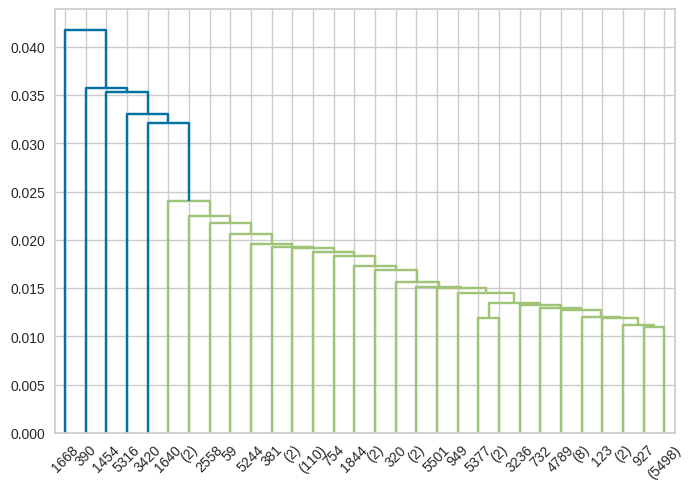

In [ ]:
hierarchical(method='single', metric='cosine')

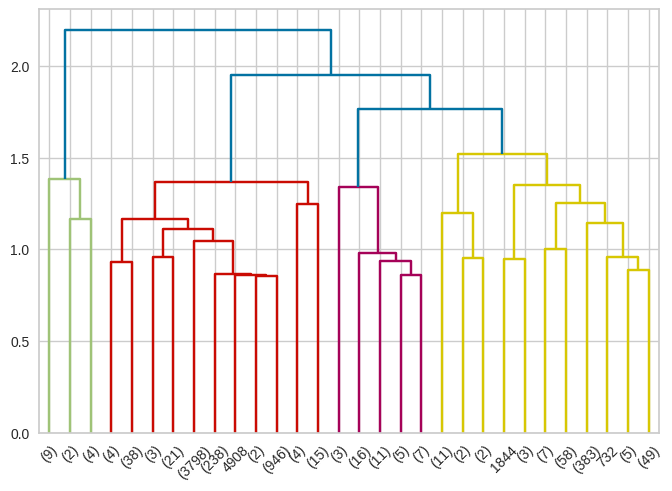

In [ ]:
hierarchical(method='average', metric='cityblock')

In [ ]:
# Add a small constant to the data to avoid division by zero
df_transformed += 1e-10


In [ ]:
# Check for zero vectors
zero_vectors = np.all(df_transformed == 0, axis=1)
print("Number of zero vectors:", np.sum(zero_vectors))


Number of zero vectors: 0


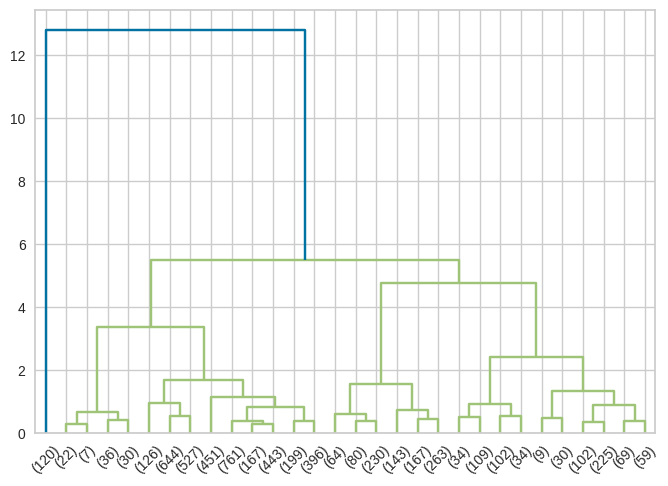

In [ ]:
hierarchical(method='ward', metric='cosine')

In [20]:
from scipy.spatial.distance import pdist
import numpy as np

# Example distance matrix calculation
data_dist = pdist(df_transformed, metric='euclidean')

# Check for any non-finite values in the distance matrix
if np.any(np.isnan(data_dist)) or np.any(np.isinf(data_dist)):
    print("Distance matrix contains non-finite values.")
else:
    print("Distance matrix is fine. No non-finite values.")


Distance matrix is fine. No non-finite values.


In [22]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, cophenet
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Assuming 'df_transformed' is your preprocessed dataset

methods = ['single', 'average', 'ward']
metrics = ['euclidean', 'cityblock', 'euclidean']  # Change according to your actual usage in hierarchical()

# Initialize lists to store evaluation results
silhouette_scores = []
cophenetic_coeffs = []

for method, metric in zip(methods, metrics):
    # Generate the linkage matrix
    data_dist = pdist(df_transformed, metric=metric)
    # Before performing linkage, check for any negative distances
    if np.any(data_dist < 0):
        print(f"Negative distances found with {method} and {metric}. Adjusting...")
        data_dist[data_dist < 0] = 0  # Adjusting negative distances if any

    data_link = linkage(data_dist, method=method)
    print(f"Linkage computed successfully for {method} with {metric}.")

    # Calculate Cophenetic Correlation Coefficient
    cophenet_coeff, coph_dists = cophenet(data_link, data_dist)
    cophenetic_coeffs.append(cophenet_coeff)

    # Assign clusters
    cluster_labels = fcluster(data_link, t=3, criterion='maxclust')  # Adjust 't' based on your specific cluster cut-off

    # Calculate Silhouette Score
    silhouette_avg = silhouette_score(df_transformed, cluster_labels)
    silhouette_scores.append(silhouette_avg)


# Print the evaluation results
for i, method in enumerate(methods):
    print(f"Method: {method}, Metric: {metrics[i]}, Silhouette Score: {silhouette_scores[i]}, Cophenetic Coefficient: {cophenetic_coeffs[i]}")


Linkage computed successfully for single with euclidean.
Linkage computed successfully for average with cityblock.
Linkage computed successfully for ward with euclidean.
Method: single, Metric: euclidean, Silhouette Score: 0.6717812653742155, Cophenetic Coefficient: 0.7317865292818526
Method: average, Metric: cityblock, Silhouette Score: 0.5461100169782008, Cophenetic Coefficient: 0.8085944257262262
Method: ward, Metric: euclidean, Silhouette Score: 0.32064217754254887, Cophenetic Coefficient: 0.6414658998110447


# **GMM**

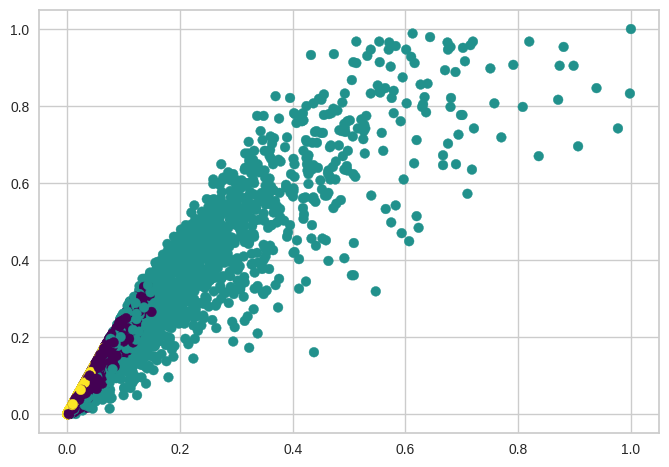

In [12]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Assuming 'df_transformed' is your dataset
# Fit a GMM model
gmm = GaussianMixture(n_components=3, random_state=0)
gmm.fit(df_transformed)

# Predict cluster labels
labels = gmm.predict(df_transformed)

# Plotting the clusters if the data is 2D
plt.scatter(df_transformed[:, 0], df_transformed[:, 1], c=labels, cmap='viridis')
plt.show()


In [13]:
from sklearn.metrics import silhouette_score

# Assuming 'df_transformed' is your dataset and 'labels' are the cluster labels predicted by the GMM
silhouette_avg = silhouette_score(df_transformed, labels)
print(f"The average silhouette score is: {silhouette_avg}")


The average silhouette score is: 0.16918981276420156


In [14]:
# Calculate BIC and AIC for the GMM
bic = gmm.bic(df_transformed)
aic = gmm.aic(df_transformed)

print(f"BIC: {bic}")
print(f"AIC: {aic}")


BIC: -160596.75522919997
AIC: -161307.15324765377
